Recommendations based on item information. Now its genres information. Data transformed to vectors and dimensions reduced with TSNE algorithm. Then it clustered with Agglomeration ward-linkage algorithm and sorted by views count inside each cluster. Clusters are meta-categories from which initial recommendation can be pulled

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [128]:
DOMAIN = 'mint'
path = '../../data/interim/{}/genres.json'.format(DOMAIN)
data = json.load(open(path))
features = pd.read_csv('../../data/interim/{}/items_features.csv'.format(DOMAIN))
print(len(data), 'unique items')

13110 unique items


## Get list of unique genres

In [129]:
genres = set()
for item in data:
    for g in item['genres']:
        genres.add(g)
genres = sorted(list(genres))
len(genres)

41

## Map items to vectors
to binary encoded genre vectors

take only items that have been viewed at least once and have genres info

In [130]:
items = [x['genres'] for x in data]
ids = [x['id'] for x in data]
        
# filter by number of reads. It can significally descrease number of useless vectors
features = features[features.views > 5]
    
# take only items that have been viewed at least once and have genres info
ids_genres = ids
ids_views = features.item_id.drop_duplicates().tolist()
common_ids = set(ids_genres).intersection(set(ids_views))
# clean genres items
isnt_none = lambda item: item is not None
for i in range(len(ids)):
    if ids[i] not in common_ids:
        ids[i] = None
        items[i] = None
ids = list(filter(isnt_none, ids))
items=list(filter(isnt_none, items))
print(len(ids), 'items left')

# get views count for each item
views_n = []
for idx in ids:
    views = features[features.item_id == idx].views
    if len(views) == 0:
        views_n.append(0)
    else:
        views_n.append(views.item())

    
items[:2]

12951 items left


[['yaoi', 'comedy', 'action', 'romance', 'drama'],
 ['comedy', 'josei', 'erotica', 'romance']]

In [131]:
mapping = {g: i for i,g in enumerate(genres)}

In [132]:
def encode_binary(items):
    global mapping
    
    onehot = lambda genre: [0 if x!=mapping[genre] else 1 for x in range(len(mapping))]
    oh_encoded = np.array(list(map(onehot, items)))
    
    
    if len(items) == 0:
        return np.zeros((len(mapping, )))
    if len(items) == 1:           
        return oh_encoded[0]
    
    return oh_encoded.sum(axis=0)

In [133]:
genre_vectors = list(map(encode_binary, items))
genre_vectors = np.stack(genre_vectors)
genre_vectors

array([[1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [134]:
genre_vectors.shape

(12951, 41)

# Explore duplications

In [135]:
from collections import Counter
c = Counter()

for vec in genre_vectors:
    c[tuple(vec)] += 1
    
len(c)

3787

In [136]:
[item[1] for item in c.most_common(20)]

[1678,
 339,
 316,
 307,
 262,
 262,
 240,
 205,
 183,
 172,
 160,
 118,
 115,
 113,
 105,
 104,
 100,
 95,
 85,
 84]

## Compress subsample of vectors

In [137]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE as tsne
import matplotlib
%matplotlib inline

In [138]:
n = len(ids)
subpart = genre_vectors[:n]
subpart_ids = ids[:n]
subpart_views = views_n[:n]
subpart.shape

(12951, 41)

In [139]:
emb = tsne(n_components=2, n_iter=4000).fit_transform(subpart)
print(emb.shape)

(12951, 2)


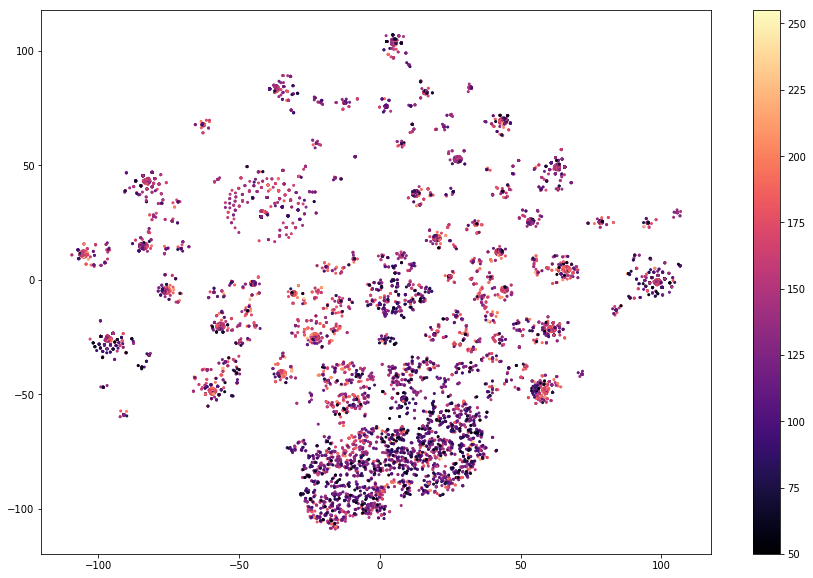

In [140]:
# plot clusters. Color indicates number of views

# calc colors
from math import log1p as log
max_views = log(max(subpart_views))
color_values = list(map(lambda v: int(log(v)/max_views*255), subpart_views))
vmin = min(color_values)
vmax = max(color_values)

# draw fig
fig, ax = plt.subplots(figsize=(15, 10))
sc = ax.scatter(emb[:, 0], emb[:, 1], 
                s=4,
                c=color_values, vmin=vmin, vmax=vmax, cmap=plt.cm.get_cmap('magma'))
fig.colorbar(sc, ax=ax)
plt.savefig('../vizualizations/{}_popularity_clusters.png'.format(DOMAIN), dpi=250)

## Clasterize compressed vectors

In [141]:
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
import matplotlib
import random

In [142]:
def rand_color():
    return [random.randint(0, 255)/255 for _ in range(3)] + [1]
colors = [rand_color() for _ in range(100)] + [(0,0,0,1)]

In [147]:
clustering = DBSCAN(eps=2.5, min_samples=40).fit(emb)
labels = clustering.labels_
len(set(labels))

67

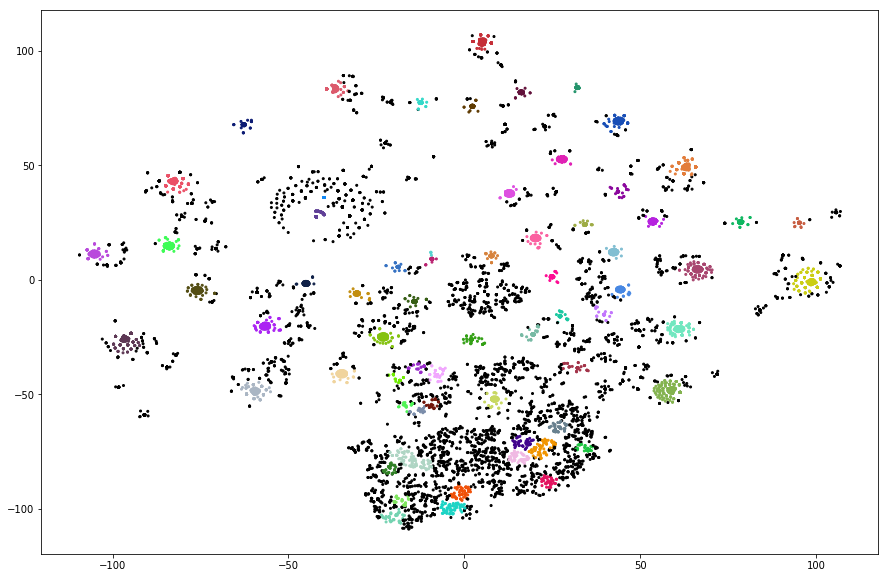

In [148]:
f = plt.figure(figsize=(15, 10))
plt.scatter(emb[:, 0], emb[:, 1], s=4, c=[colors[lab] for lab in labels])
plt.savefig('../vizualizations/{}_clusterization.png'.format(DOMAIN), dpi=250)

# Build claster top populars

In [149]:
# cluster label -> item ixs in the dataset. Not its ids!
clusters_views = dict()
clusters_ids = dict()

for lab in set(labels):
    if lab == -1:
        continue
    ixs = [i if labels[i]==lab else None for i in range(len(labels))]
    ixs = list(filter(lambda i: i is not None, ixs))
    category_views = [subpart_views[i] for i in ixs]
    category_ids =   [subpart_ids[i] for i in ixs]

    sorted_items = sorted(zip(category_views, category_ids), key=lambda p: -p[0])
    clusters_views[lab] = [x[0] for x in sorted_items]
    clusters_ids[str(lab)] = [x[1] for x in sorted_items]

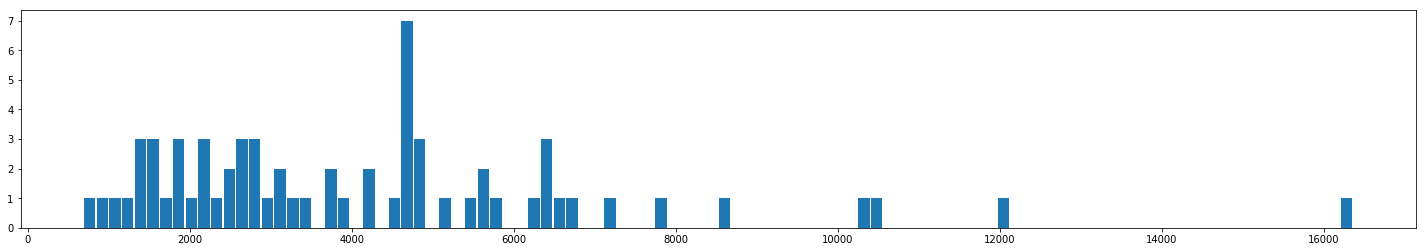

In [150]:
# top popular item views per each cluster
_ = plt.figure(figsize=(25, 4))
_ = plt.hist([views[0] for views in clusters_views.values()], bins=100, rwidth=0.9)

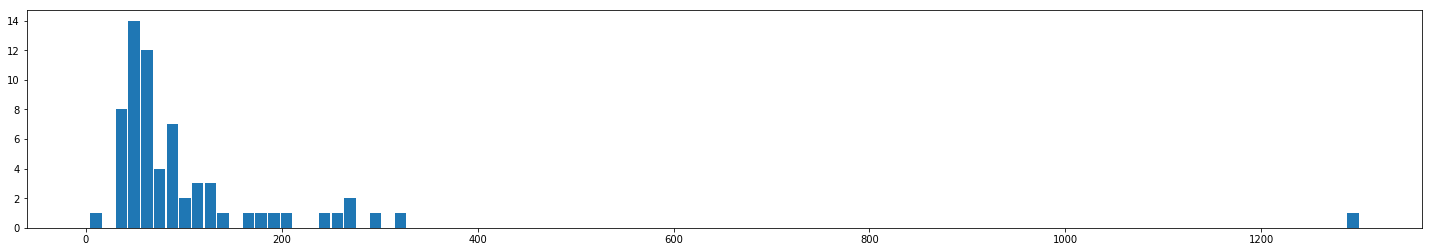

In [151]:
# size of each cluster
_ = plt.figure(figsize=(25, 4))
_ = plt.hist([len(views) for views in clusters_views.values()], bins=100, rwidth=0.9)

In [153]:
# save top popular ids per claster
del_ids = []
for k, v in clusters_ids.items():
    if max(clusters_views[int(k)]) < 3000:
        # delete clusters of unpopular items
        del_ids.append(k)
    else:
        clusters_ids[k] = v[:30]
for idx in del_ids:
    del clusters_ids[idx]

print(len(clusters_ids), 'categories left')

38 categories left


In [154]:
json.dump(clusters_ids, open('../../data/processed/{}/explorational_recs.json'.format(DOMAIN), 'w'))